http://rocksandwater.net/blog/2014/01/eq-cycle-stress/

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
#config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.animation as animation
from tempfile import NamedTemporaryFile
from IPython.display import HTML

In [3]:
VIDEO_TAG = """<video controls>
<source src="data:video/x-m4v;base64,{0}" type="video/mp4">
Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, dpi=100,
                      extra_args=['-vcodec', 'libx264',
                                  '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
        
    return VIDEO_TAG.format(anim._encoded_video)


def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html( anim) )

animation.Animation._repr_html_ = anim_to_html

##**One fixed stress component**

My first notions of this were that one of the principal stresses stays constant throughout the earthquake cycle, while the other principal stress varies 1. Once τ=τf, i.e. the shear stress τ reaches the failure shear stress τf for that particular normal stress (this is the Mohr-Coulomb failure envelope), there is an earthquake.

1I am not sure this is correct, and Eric Hetland disagrees with me on this; there are some particular implications for normal stress drop during earthquakes that may be problematic. I have also implemented a model (at the end) where the normal stress stays constant. I also am not sure this is correct…

I'm also not going to provide a much of a description of Mohr circles here. Suffice it to say that they are a graphical and quantitative representation of the state of stress at a point, and the normal and shear stresses on a plane of any orientation are represented as points on the Mohr circle itself. The venerable Steven Dutch has a good page here for an introduction.

###**Thrust fault**

Fault dips 30∘. Maximum principal stress s1 is horizontal, and minimum principal stress s2 is vertical.

During the course of the interseismic period, s1 increases with time to failure; s2 is constant in this model.


In [4]:
s2 = 20
s1 = np.array([20, 30, 40, 50, 60, 70, 80, 90, 100])

s_ = (s1 + s2) / 2.# mean stress
r_ = (s1 - s2) / 2.# radius of Mohr circle

s_f = s_ + (r_ * np.cos(2 * np.pi / 3) )#normal stress at failure
t_f = r_ * np.sin(2 * np.pi / 3)#shear stress at failure

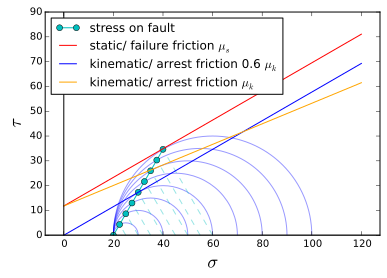

In [15]:


fig = figure()

for i, s in enumerate(s_):
    fig.gca().add_artist( Circle( (s, 0), r_[i], fill=False, 
                                 color='b', alpha=0.4) )
    
    plot([s, s_f[i]], [0, t_f[i]], 'c--', alpha=0.4)
    

# 
plot(s_f, t_f, 'co-', label='stress on fault')

# plot failure envelope, coeff. fric. = 0.6
plot(np.array([0,120]), (np.tan( np.pi/6.)* np.array([0,120]) + 11.8), 
     'r', label=r'static/ failure friction $\mu_s$')

plot(np.array([0,120]), (np.tan( np.pi/6.)* np.array([0,120])),
     'blue', label='kinematic/ arrest friction 0.6 $\mu_k$')

plot(np.array([0,120]), (np.tan( np.pi/8.)* np.array([0,120]) + 11.8),
     'orange', label='kinematic/ arrest friction $\mu_k$')

axvline(color='k')
axhline(color='k')
axis('equal')
xlabel(r'$\sigma$', fontsize=18)
ylabel(r'$\tau$', fontsize=18)
legend(loc='upper left')

show()



_Mohr circles showing the stress at different points in the earthquake cycle. Cyan circles indicate τ and σ on the fault plane; the solid cyan line connecting them represents the stress path the fault can take. The dashed lines go to the mean stress for each Mohr circle._

OK, so what does this show? In this plot, we see that as s1 increases from its initial equality with s2, all stresses not aligned with s2 (which is roughly vertical for shallow thrust faulting) increase. So the horizontal s1 and the differential stress (the diameter of the circle) increase, until the circle touches the red line, which is the Mohr-Coulomb failure envelope (the slope of which is μk, the static fault friction). Note that dτ/dσ on the fault plane (represented by the cyan points and line) is much greater than μ, so inevitably as s1 increases, the τ/σ will hit the failure envelope.

Then, although it's not super apparent here, the fault starts slipping in an earthquake.

What happens during an earthquake is pretty complicated, and I won't try to represent it with a Mohr circle (maybe once I understand it better I will). But one thing that is certain is that μk, the kinematic fault friction (orange line), is less than μs, the static fault friction (red line). μk is almost certainly variable through the earthquake, as described by rate-state friction laws.

As the fault slips, τ is reduced as the stored elastic energy is used up in slip, heating, seismic radiation, etc. So the circle decreases, until it hits the orange line, below which the fault is stable again: τ can't overpower σ anymore.

That is sweet! But, it's hard to see in the context of an 'earthquake cycle'.

So let's make a video that shows repeated earthquakes.


In [6]:
#set up steps

s1a = range(20,101)
s1a.append(90)
s1a.extend( range(80,101) )
s1a.append(90)
s1a.extend( range(80,101) )
s1a.append(90)
s1a.extend( range(80,101) )

s1a = np.array(s1a)

AttributeError: 'range' object has no attribute 'append'

In [7]:
# make animation
fig, ax = subplots()

# plot failure envelope, coeff. fric. = 0.6
plot(np.array([0,120]), (np.tan( np.pi/6.)* np.array([0,120]) 
                         + 11.8), 'r', alpha=1, label=r'$\mu_s = 0.6$')

plot(np.array([0,120]), (np.tan( np.pi/8.)* np.array([0,120]) 
                         + 11.8), 'orange', alpha=1, label=r'$\mu_k = 0.4$')
legend(loc='upper left')

axvline(color='k')
axhline(color='k')
axis('equal')
xlabel(r'$\sigma$', fontsize=18)
ylabel(r'$\tau$', fontsize=18)


mohr = Circle( (-10, 0), radius=0, fill=False,
                      color = 'b', alpha=1)

fail_pt, = ax.plot( [], [], 'co')

def init():
    fail_pt.set_data([], [])
    mohr.center = (20, 20)
    mohr.radius = 0
    ax.add_patch(mohr)

    return (mohr, fail_pt,)
    
def update(s1a):
    s2a = 20
    
    sa_ = (s1a + s2a) / 2.
    ra_ = (s1a - s2a) / 2.
    
    sa_fail = sa_ + ra_ * np.cos(2 * np.pi / 3.)
    ta_fail = ra_ * np.sin(2 * np.pi / 3.)
    
    fail_pt.set_data([sa_fail], [ta_fail])
    mohr.center = (sa_, 0)
    mohr.radius = (ra_)

    return (mohr, fail_pt,)

anim = animation.FuncAnimation(fig, update, init_func = init,
                               frames = s1a, blit=True)

#anim.save('fail_anim.mp4', dpi=200, fps=20)

#show()
display_animation(anim)



E:\WinPython-64bit-3.4.3.4\python-3.4.3.amd64\lib\site-packages\matplotlib\animation.py:742: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


RuntimeError: Error creating movie, return code: 4 Try running with --verbose-debug

So hopefully this makes it a little more clear: stress increases until the Mohr circle reaches the failure envelope, then an earthquake happens and stress is reduced until the Mohr circle reaches the arrest envelope.

Now let's look at a normal faulting event.

###**Normal faulting**

The setup is a little different here. Fault dips at 60 degrees. s1 constant at 100, s2 decreases with time(!) This was counter-intuitive to me, but it's important to remember that tectonic stress is tensional in normal faulting environments, but the lithostatic pressure is high enough that the faults are still under compression. See Mancktelow 2008 for a discussion on this; he refers to the situation as 'tectonic underpressure', because the mean normal stress (the pressure) is below lithostatic.


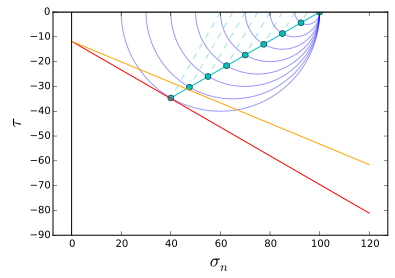

In [8]:
ns1 = 100
ns3 = np.array([100, 90, 80, 70, 60, 50, 40, 30, 20])

ns_ = (ns1 + ns3) / 2.
nr_ = (ns1 - ns3) / 2.

ns_f = ns_ + (nr_ * np.cos(2 * np.pi / 3) )
nt_f = -(nr_ * np.sin(2 * np.pi / 3) )
fig = figure()

for i, s in enumerate(ns_):
    fig.gca().add_artist( Circle( (s, 0), r_[i], fill=False, color='b',
                                 alpha=0.4) )
    plot([s, ns_f[i]], [0, nt_f[i]], 'c--', alpha=0.4)

plot(ns_f, nt_f, 'co-')

plot(np.array([0,120]), -(np.tan( np.pi/6.)* np.array([0,120])  
                         + 11.8), 'r')

plot(np.array([0,120]), -(np.tan( np.pi/8.)* np.array([0,120]) 
                         + 11.8), 'orange')

axvline(color='k')
axhline(color='k')
axis('equal')
xlabel(r'$\sigma_n$', fontsize=18)
ylabel(r'$\tau$', fontsize=18)
show()

In [9]:
# set up steps, using s_2 as the steps in the animation

ns1a = 100

ns2a = range(20,101)[::-1]
ns2a.append(25)
ns2a.extend( range(20,31)[::-1])
ns2a.append(25)
ns2a.extend( range(20,31)[::-1])
ns2a.append(25)
ns2a.extend( range(20,31)[::-1])
ns2a.append(25)
ns2a.extend( range(20,31)[::-1])

ns2a = np.array(ns2a)

# make animation

fig, ax = subplots()

# plot failure envelope, coeff. fric. = 0.6
plot(np.array([0,120]), -(np.tan( np.pi/6.)* np.array([0,120])  
                         + 11.8), 'r', label=r'$\mu_s = 0.6$')

# plot arrest envelope, coeff. fric. = 0.4
plot(np.array([0,120]), -(np.tan( np.pi/8.)* np.array([0,120]) 
                         + 11.8), 'orange', label=r'$\mu_k = 0.4$')
legend(loc='lower left')

# axis and labels
axvline(color='k')
axhline(color='k')
axis('equal')
xlabel(r'$\sigma$', fontsize=18)
ylabel(r'$\tau$', fontsize=18)

# mohr cirlces
mohr = Circle( (-10, 0), radius=0, fill=False, color='b')

fail_pt, = ax.plot( [], [], 'co')

def init():
    fail_pt.set_data([], [])
    mohr.center = (100, 0)
    mohr.radius = 0
    ax.add_patch(mohr)
    
    return (mohr, fail_pt)


def update(ns2a):
    ns1a = 100
    
    nsa_ = (ns1a + ns2a) / 2.
    nra_ = (ns1a - ns2a) / 2.
    
    nsa_fail = nsa_ + (nra_ * np.cos(2 * np.pi / 3) )
    nta_fail = -(nra_ * np.sin(2 * np.pi / 3) )
    
    fail_pt.set_data([nsa_fail], [nta_fail])
    mohr.center = (nsa_, 0)
    mohr.radius = (nra_)
    
    return (mohr, fail_pt)

anim = animation.FuncAnimation(fig, update, init_func = init,
                               frames = ns2a, blit=True)

display_animation(anim)

AttributeError: 'range' object has no attribute 'append'



Edifying.

To the extent that these toy models are correct, there are some interesting differences between the thrust and normal cases. One of them is that the stress drop is a lot less; Δs2 in the normal fault model is about 10, which is half of Δs1 in the thrust fault model. This means that for a given shear stress accumulation rate, earthquakes would be smaller and more frequent. However, continental normal faults typically have much lower slip rates than thrust faults (you heard it here first folks), so it may be difficult to find good datasets to compare this to in the field or literature.

Earlier I mentioned that Hetland has an issue with the stress evolution as depicted above. This problem is that in a nice double-couple earthquake, there is no reduction in normal stress during slip. But clearly, normal stress increases during the interseismic period, as shown by the path of the blue dot in these videos.

This leaves us with a handful of options:

- Normal stress is actually constant during the interseismic period.
- Normal stress decreases postseismically.
- Normal stress actually does decrease coseismically, and we just don't see it in the radiated energy.

I am going to look at the first option. The second one seems great, but I don't know how to evaluate it. The third one is appealing to me, but the seismologists disagree.
